# Interval 1: ROI 1

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider
import numpy as np

import astropy
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a
from sunpy.map import make_fitswcs_header
from sunpy.coordinates import propagate_with_solar_surface

import skimage
import scipy

import glob
import os
import shutil
from copy import deepcopy
import pickle
from pathlib import Path
import math

from tqdm import tqdm

from scipy.signal import savgol_filter

from matplotlib.animation import PillowWriter

from sunpy.net.jsoc import JSOCClient

### Define function to read in saved pickle files

In [4]:
# define read-in function
def read_from_pickle_chunks(base_filename, num_parts):
    all_data = []

    for i in range(1, num_parts + 1):
        part_file = Path(f"{base_filename}_part{i}.pickle")
        with open(part_file, "rb") as f:
            chunk = pickle.load(f)
            all_data.extend(chunk)

    return sunpy.map.Map(all_data, sequence=True)

Read in pickle files from "Interval_1"...

In [5]:
# projection information
aia171_aligned = read_from_pickle_chunks('aia171_data_interval1', 10)
aia1700_aligned = read_from_pickle_chunks('aia1700_data_interval1', 5)
iris1400_aligned = read_from_pickle_chunks('iris1400_data_interval1', 3)
eui_aligned = read_from_pickle_chunks('eui174_data_interval1', 4)

# time information
aia171_matched = read_from_pickle_chunks('aia171_matched_interval1', 10)
aia1700_matched = read_from_pickle_chunks('aia1700_matched_interval1', 5)
iris1400_matched = read_from_pickle_chunks('iris1400_matched_interval1', 3)
eui174_matched = read_from_pickle_chunks('eui174_matched_interval1', 4)

View side-by-side movie for ROI 1...

![SegmentLocal](gifs/eui_and_iris_interval1.gif "Aligned EUI 174 and IRIS 1400")

View frame-by-frame...

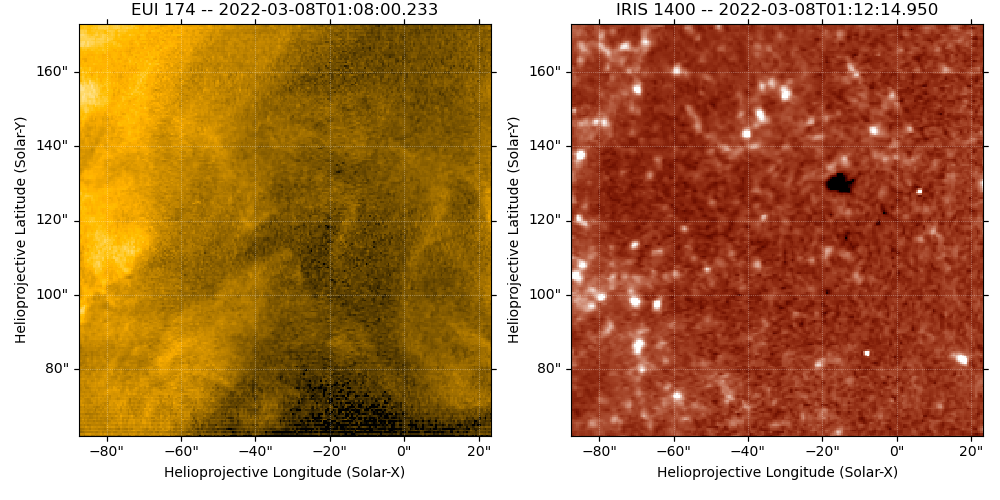

In [32]:
i = 300 # adjust i to choose frame; i = [0, 359]

eui_map = eui_aligned[i]
iris_map = iris1400_aligned[i]

eui_norm = ImageNormalize(eui_map.data, vmin=400, vmax=1500, stretch=SqrtStretch())
iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=15, stretch=SqrtStretch())

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121, projection=eui_map)
eui_map.plot(axes=ax1, norm=eui_norm, title=f'EUI 174 -- {eui174_matched[i].date}')

ax2 = fig.add_subplot(122, projection=iris_map, sharex=ax1, sharey=ax1)
iris_map.plot(axes=ax2, norm=iris_norm, title=f'IRIS 1400 -- {iris1400_matched[i].date}')

ax1.set_xlim(25, 250)
ax1.set_ylim(25, 250)

plt.tight_layout()

### Use interactive plot to investigate brightenings

In [30]:
# define function for updating maps
def show_frame(i):
    eui_map = eui_aligned[i]
    iris_map = iris1400_aligned[i]

    eui_norm = ImageNormalize(eui_map.data, vmin=400, vmax=1500, stretch=SqrtStretch())
    iris_norm = ImageNormalize(iris_map.data, vmin=0, vmax=15, stretch=SqrtStretch())
    
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(121, projection=eui_map.wcs)
    eui_map.plot(axes=ax1, norm=eui_norm, title=f'EUI 174 -- {eui174_matched[i].date}')

    ax2 = fig.add_subplot(122, projection=iris_map.wcs, sharex=ax1, sharey=ax1)
    iris_map.plot(axes=ax2, norm=iris_norm, title=f'IRIS 1400 -- {iris1400_matched[i].date}')

    ax1.set_xlim(25, 250)
    ax1.set_ylim(25, 250)

    plt.tight_layout()
    plt.show()

# create slider widget
interact(show_frame, i=IntSlider(min=0, max=len(eui_aligned)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=359), Output()), _dom_classes=('widget-interact'…

<function __main__.show_frame(i)>

### Record observations of EUI brightenings...

Note: Frames start at 0. Therfore, if $\textit{i}$ = $\textit{n}$, then you are looking at the $\textit{i} + 1 ^{th}$ frame.

EUI 174:

1. center at start time            ~ (-29, 131) arcsecs
   
   start time/frame                ~ 00:43:15.239 UT / $\textit{i} = 3$

   center at end time              ~ (-26, 132) arcsecs

   end time/frame                  ~ 00:45:15.227 UT / $\textit{i} = 27$
   
   duration                        ~ 119.988 $\pm$ 5 seconds

2. ...

IRIS 1400:

1. Does it appear?                        ~ Unclear; bright spot exists prior to EUI visibility; drifts throughout EUI duration
2. ...

Will record remaining observations in Microsoft Excel